In [2]:
!pip install pandas numpy scikit-learn tensorflow torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.6/766.6 MB 7.9 MB/s eta 0:00:0000:0100:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 8.3 MB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 7.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 8.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 8.4 MB/s eta 0:00:0000:0100:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.1/150.1 MB 7.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━

['LATITUDE', 'LONGITUDE', 'START_DATE', 'FUEL_TYPE', 'FIRE', 'temperature', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'weather', 'lightning_count_index', 'lightning_days_index', 'dist_to_urban_km', 'urban_type', 'urban_population_density', 'urban_dwelling']

 Features used for training:
['FUEL_TYPE', 'temperature', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'weather', 'lightning_count_index', 'lightning_days_index', 'dist_to_urban_km', 'urban_type', 'urban_population_density', 'urban_dwelling']

 Target to predict: 'FIRE'


🧾 Fold 1 Class Distribution:
Train: {0.0: 4846, 1.0: 720}
Test : {0.0: 1211, 1.0: 181}
>>> Fold 1 | Epoch 1 | Avg Epoch Loss: 0.5506 | Test Acc: 0.8700
>>> Fold 1 | Epoch 2 | Avg Epoch Loss: 0.3717 | Test Acc: 0.8700
>>> Fold 1 | Epoch 3 | Avg Epoch Loss: 0.3568 | Test Acc: 0.8700
>>> Fold 1 | Epoch 4 | Avg Epoch Loss: 0.3404 | Test Acc: 0.8700
>>> Fold 1 | Epoch 5 | Avg Epoch Loss: 0.3240 | Test Acc: 0.8700
>>> Fold 1 | Epoch 6 | Avg Epoch Loss: 0.31

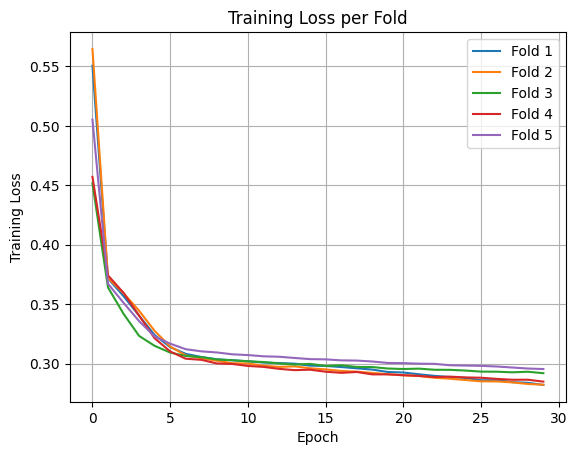

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Load CSV
df = pd.read_csv("/mnt/d/446Project/WeatherTransformer/data_processing/Processed/wildfire_features_merged_2024.csv")
print(df.columns.tolist())
df = df.loc[:, ~df.columns.str.contains("latitude|longitude|date|tude", case=False)]

# df = df.drop(columns=["LONGITUDE"])

df["FIRE"] = df["FIRE"].astype(float)

# Identify and clean number-like strings with commas
for col in df.columns:
    if df[col].dtype == 'object':
        # Remove commas and convert to float if possible
        try:
            df[col] = df[col].str.replace(",", "").astype(float)
        except:
            pass  # If it fails, likely categorical, leave it for one-hot encoding

# Separate features and label
label = df["FIRE"].values.astype(np.float32)
features = df.drop(columns=["FIRE"])
# features = features.drop(columns=["Unnamed: 0"])
# Show input features and target
print("\n Features used for training:")
print(features.columns.tolist())

print(f"\n Target to predict: 'FIRE'\n")


# One-hot encode remaining categorical columns (if any)
features = pd.get_dummies(features)

# Scale features
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Convert to tensors
X = torch.tensor(features_scaled, dtype=torch.float32)
y = torch.tensor(label, dtype=torch.float32)

# Define model architecture
class FireClassifier(nn.Module):
    def __init__(self, input_size):
        super(FireClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# Cross-validation
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
accuracies = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    train_classes, train_counts = torch.unique(y_train, return_counts=True)
    test_classes, test_counts = torch.unique(y_test, return_counts=True)

    print(f"\n🧾 Fold {fold+1} Class Distribution:")
    print(f"Train: {dict(zip(train_classes.tolist(), train_counts.tolist()))}")
    print(f"Test : {dict(zip(test_classes.tolist(), test_counts.tolist()))}")

    # Create DataLoaders
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Model, loss, optimizer
    model = FireClassifier(input_size=X.shape[1]).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop with loss tracking
    model.train()
    num_epochs = 30
    train_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        batch_count = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device).view(-1, 1)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

            batch_loss = loss.item()
            epoch_loss += batch_loss * xb.size(0)
            batch_count += 1

            # Per-batch loss
            # print(f"Fold {fold+1} | Epoch {epoch+1} | Batch {batch_count} | Batch Loss: {batch_loss:.4f}")

        avg_loss = epoch_loss / len(train_loader.dataset)
        train_losses.append(avg_loss)

        # === Evaluation on test set ===
        model.eval()
        all_preds = []
        with torch.no_grad():
            for xb, _ in test_loader:
                xb = xb.to(device)
                preds = model(xb)
                all_preds.extend(preds.cpu().numpy())

        binary_preds = (np.array(all_preds) > 0.5).astype(int).flatten()
        test_acc = accuracy_score(y_test.numpy(), binary_preds)
        test_accuracies.append(test_acc)

        print(f">>> Fold {fold+1} | Epoch {epoch+1} | Avg Epoch Loss: {avg_loss:.4f} | Test Acc: {test_acc:.4f}")

    # Plot loss for this fold
    plt.plot(train_losses, label=f"Fold {fold+1}")


    # Evaluation
    model.eval()
    all_preds = []
    with torch.no_grad():
        for xb, _ in test_loader:
            xb = xb.to(device)
            preds = model(xb)
            all_preds.extend(preds.cpu().numpy())
    
    # Convert predictions to binary
    binary_preds = (np.array(all_preds) > 0.5).astype(int).flatten()
    acc = accuracy_score(y_test.numpy(), binary_preds)
    accuracies.append(acc)

# Report
print(f"{k_folds}-fold cross-validation accuracies: {accuracies}")
print(f"Average accuracy: {np.mean(accuracies):.4f}")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss per Fold")
plt.legend()
plt.grid(True)
plt.show()



In [32]:
torch.save(model.state_dict(), f"fire_model_fold_{2}.pt")
model.load_state_dict(torch.load("fire_model_fold_2.pt"))
model.eval()

RuntimeError: File fire_model_fold_2.pt cannot be opened.

In [ ]:
import joblib

# After you finish training
joblib.dump(scaler, "scaler.pkl")
joblib.dump(features.columns.tolist(), "feature_columns.pkl")
import pandas as pd
import numpy as np
import torch
import joblib

# Load saved artifacts
scaler = joblib.load("scaler.pkl")
feature_columns = joblib.load("feature_columns.pkl")

# Load model
input_size = len(feature_columns)
model = FireClassifier(input_size=input_size)
model.load_state_dict(torch.load("fire_model_fold_openweather.pt"))  # Adjust to your path
model.eval()

def predict_fire_from_row(row_dict):
    """
    row_dict: dict containing one data entry with same keys as CSV columns
    Returns: predicted probability and binary class (0 = no fire, 1 = fire)
    """

    # Convert to DataFrame
    df = pd.DataFrame([row_dict])

    # Clean numeric strings
    for col in df.columns:
        if df[col].dtype == "object":
            try:
                df[col] = df[col].str.replace(",", "").astype(float)
            except:
                pass  # Leave as categorical

    # One-hot encode and align with training columns
    df = pd.get_dummies(df)
    for col in feature_columns:
        if col not in df.columns:
            df[col] = 0  # Add missing columns
    df = df[feature_columns]  # Ensure correct order

    # Scale
    input_scaled = scaler.transform(df)

    # Predict
    input_tensor = torch.tensor(input_scaled, dtype=torch.float32)
    with torch.no_grad():
        prob = model(input_tensor).item()
    prediction = int(prob > 0.5)

    return {"probability": prob, "predicted_class": prediction}

sample_input = {
"FUEL_TYPE": "C2",
"Spd of Max Gust (km/h)": "42",  # if missing, use ""
"Total Precip (mm)": 15.8,
"Mean Temp (°C)": 19.8,
"Min Temp (°C)": 16.0,
"Max Temp (°C)": 23.5,
"Distance to Weather Station (km)": 15.02,
"dist_to_urban_deg": 1.15,
"urban_type": "Small population centre",
"urban_population_density": "987.4",
"urban_dwelling": "2,575",
"dist_to_urban_km": 128.28
}

result = predict_fire_from_row(sample_input)
print(result)  # {'probability': 0.81, 'predicted_class': 1}



{'probability': 0.5104819536209106, 'predicted_class': 1}


/tmp/ipykernel_839337/259636423.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = 0  # Add missing columns
/tmp/ipykernel_839337/259636423.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = 0  # Add missing columns
/tmp/ipykernel_839337/259636423.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `new